# Quick Overview

This notebook provides a quick example of how to start using the `spectral_recovery` package. More detailed examples will soon become available in the [User Guide](https://people-er.github.io/Spectral-Recovery/about/).

If you want to try out the tool on your own, you can use the [test data on GitHub](https://github.com/PEOPLE-ER/Spectral-Recovery/tree/main/docs/test_data/test_data.zip).

Once the tool is installed with `pip install spectral-recovery`, you can import the package

In [1]:
import spectral_recovery as sr

## Defining a RestorationArea

To begin, we must create a `RestorationArea` object. This object holds and coordinates all the information necessary to compute recovery metrics for an area that has experienced disturbance and/or restoration. The following section briefly describes the input parameters but for more in-depth information, please see the [Spectral Recovery Tool](https://people-er.github.io/Spectral-Recovery/about/#2-the-spectral-recovery-tool) section in the User Guide.

### Input Parameters

| Name  | Type  | Description  |
|---|:---:|---|
| **restoration_polygon**  | geopandas.GeoDataFrame  | The spatial deliniation of the restoration event, i.e where disturance/restoration has occured.  |   
|  **restoration_start** | datetime | The start year of the restoration window.  |   
| **disturbance_start**  | datetime  |  The start year of the disturbance window. |  
|  **reference_polygon** | geopandas.GeoDataFrame  | The spatial deliniation of the reference systems.  |   
|  **reference_years** | list of datetime  | The year or range of years to use for determining a recovery target.  |   
|  **composite_stack** | xarray.DataArray  | The timeseries of annual composites for computing recovery metrics.   |  

### Prepping Inputs

#### Annual Composites

Next, read in your set of annual composites. To do this use the `read_and_stack_tifs` method. The method requires that you either provide a path to a directory containing all of your annual composites, or you provide a list of paths to each individual composite. Each composite:

1. _must_ be named after the year of which they are a composite, e.g for a composite of 2014 the file must be named `2014.tif`
2. _must_ have the bands named by their common names/acronyms

Each composite can contain multiple bands but each band must be present in all composites. You must also provide the Platform(s) from which the composite is derived.

| Parameter   | Options   |
|:---:|---|
|  Platform   | 'landsat_oli', 'landsat_etm', 'landsat_tm','sentinel_2' |

The set of annual composites that we'll be using in this notebook was created using the [GEE BAP tool](https://github.com/saveriofrancini/bap).

In [3]:
composite_stack = sr.read_and_stack_tifs(
    "test_data/annual_composites/landsat",
    platform=["Landsat-TM", "Landsat-ETM+", "Landsat-OLI"],
    band_names={1: "blue", 2: "green", 3: "red", 4: "nir", 5: "swir16", 6: "swir22"},
    array_type="numpy"
)

Compute your indices using the `compute_indices` function. The function takes 2 parameters 1) your image stack, 2) choice of indices.

| Parameter   | Options   |
|:---:|---|
|  Indices   | 'NDVI', 'NBR','GNDVI', 'EVI', 'AVI', 'SAVI','NDWI','TCG','TCW','TCB','SR','NDMI','GCI','NDII'  |


In [4]:
indices_stack = sr.compute_indices(
    image_stack=composite_stack, 
    indices=["NBR", "NDMI", "GNDVI"]
)

#### Polygons

Read your restoration polygon using GeoPandas

Text(0.5, 1.0, 'Test restoration polygon')

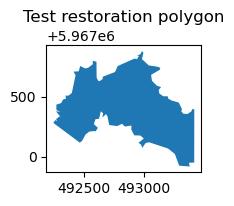

In [5]:
import geopandas as gpd

restoration_poly = gpd.read_file("test_data/wildfire_516.gpkg")
restoration_poly.plot(figsize=(2, 2)).set_title("Test restoration polygon")

#### Dates/Years

Finally, define the years we need for a restoration area: the start year of the disturbance and restoration windows. 

In [6]:
disturbance_start = "2005" # the start of the disturbance window
restoration_start ="2006" # the start of the restoration window

### Creating a RestorationArea

Now that we've prepped our input, we can create a RestorationArea and are one step closer to computing recovery metrics.

A novel feature of the `spectral_recovery` package is that it allows users to choose between using a [historic recovery target](https://people-er.github.io/Spectral-Recovery/about/#14-recovery-targets) or a [reference recovery target](https://people-er.github.io/Spectral-Recovery/about/#14-recovery-targets) when computing recovery metrics. Be sure to consult the user guide and current literature when deciding which type of target works best for computing your recovery metrics.

#### RestorationArea with Median Recovery Target

A historical recovery target is computed using historic (prior to disturbance) values from the restoration site. Historic recovery targets can either be computed on the _pixel scale_, meaning that each pixel in the restoration site has a unique recovery target, or on the _polygon scale_, where the whole polygon has a single recovery target value. 

To create a `RestorationArea` object that uses a historic recovery target, provide the restoration site and set the appopriate reference years.

In [7]:
reference_years = ["2003", "2004"] # two years prior to the disturbance window

# By default, the recovery targets are computed at the polygon scale.
ra_hist_polygon = sr.RestorationArea(
    restoration_polygon=restoration_poly,
    disturbance_start=disturbance_start, 
    restoration_start=restoration_start,
    reference_years=reference_years,
    composite_stack=indices_stack,
)

In [7]:
# Parameterize a MedianTarget method for pixel scale.
per_pixel_method = sr.targets.MedianTarget(scale="pixel")

# To compute recovery targets at the pixel scale, pass the parameterized method.
ra_hist_pixel = sr.RestorationArea(
    restoration_polygon=restoration_poly,
    disturbance_start=disturbance_start, 
    restoration_start=restoration_start,
    reference_years=reference_years,
    composite_stack=indices_stack,
    recovery_target_method=per_pixel_method
)

You can visualize the spectral trajectory of your RestorationArea using the `plot_spectral_trajectory` function. If you want to write the plot to file, pass your desired path to the function.

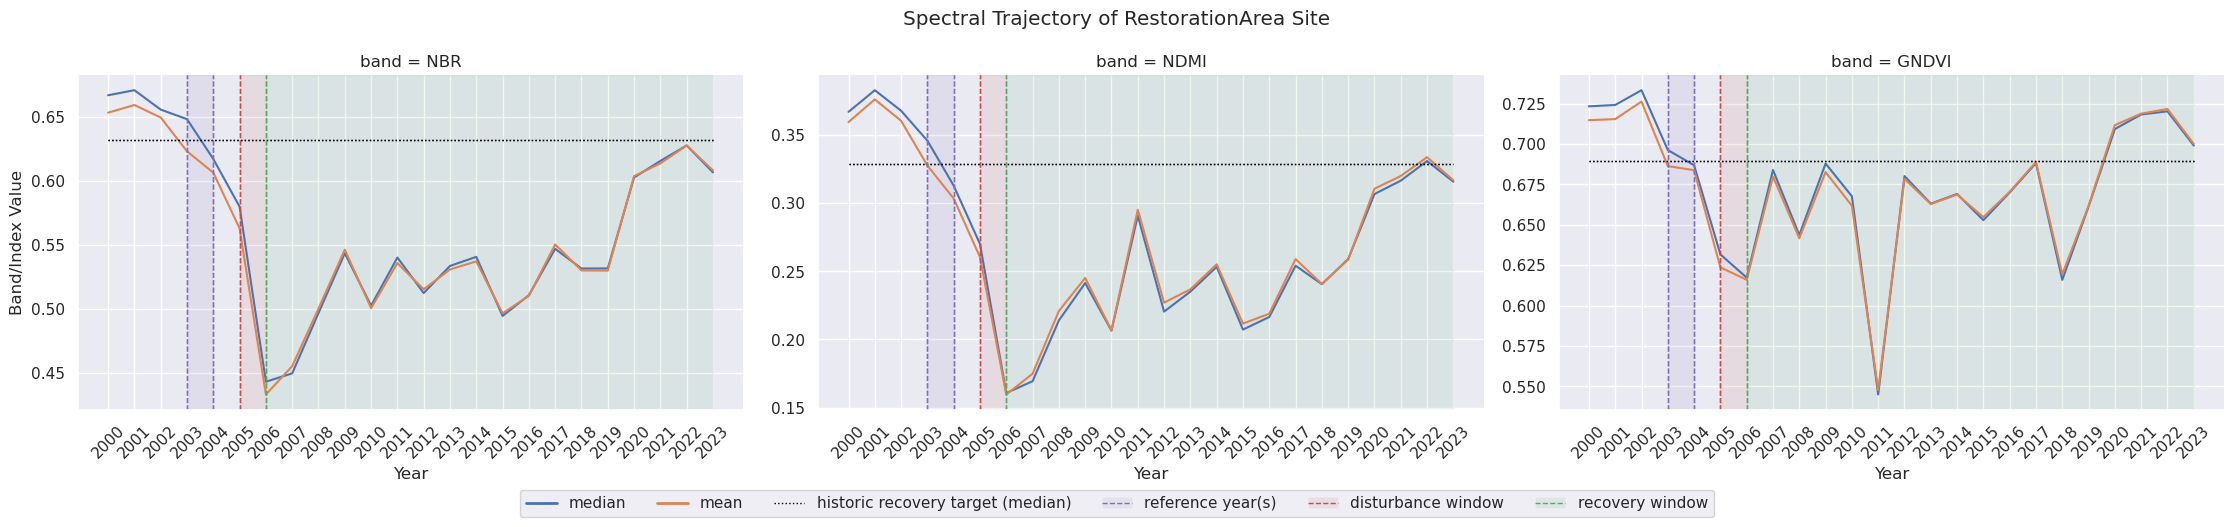

In [8]:
ra_hist_polygon.plot_spectral_trajectory()
# or
# ra_hist.plot_spectral_trajectory("path/to/your_plot.png")

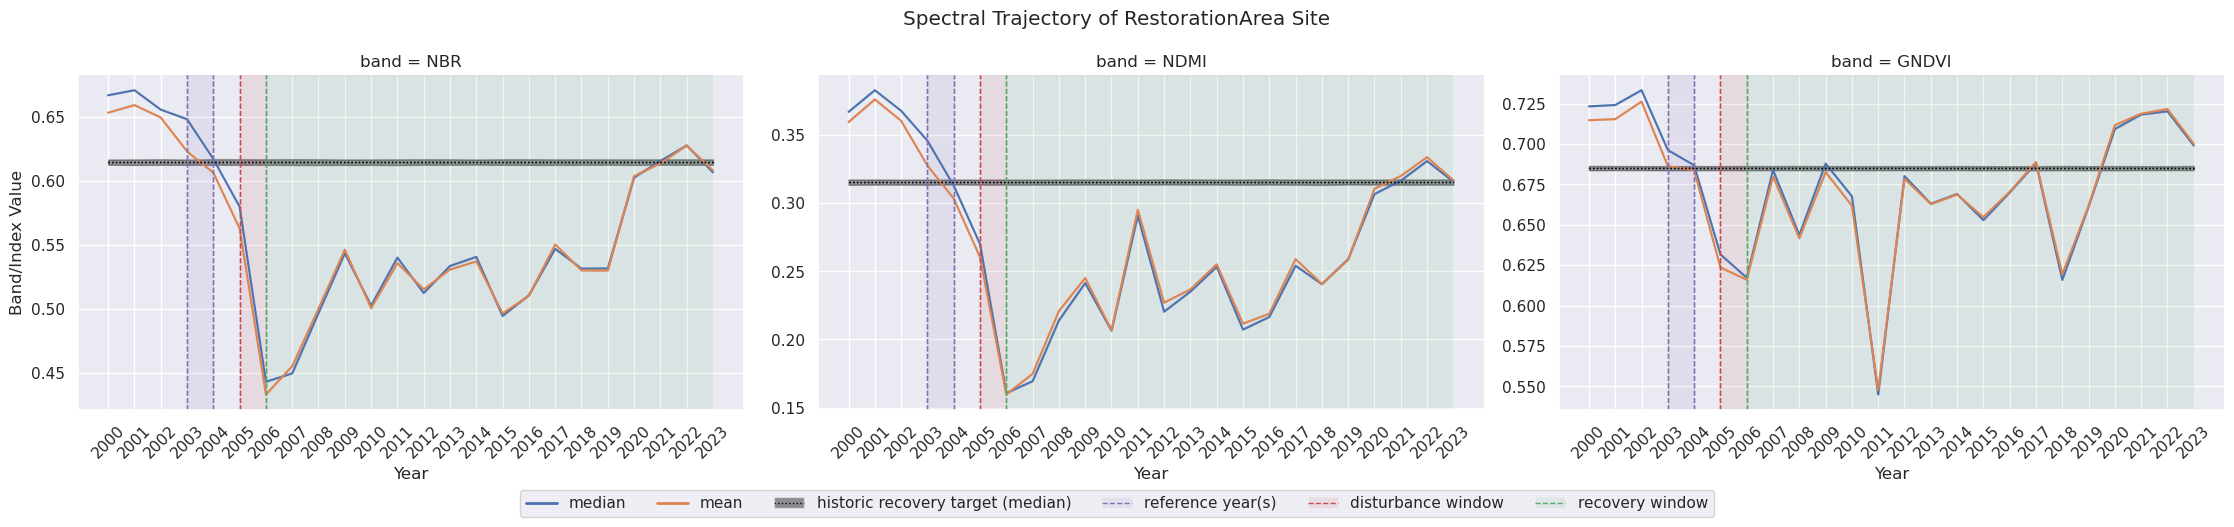

In [9]:
ra_hist_pixel.plot_spectral_trajectory()

#### RestorationArea with Reference Recovery Target

A reference recovery target is computed using an area(s) in the same landscape as the restoration site that exhibits desirable, healthy, and stable ecosystem conditions (Gann et al., 2019). Reference areas can be composed of a single or multiple polygons. If the latter, the median of all individual polygon targets is taken to be the recovery target. All reference targets are a single value (i.e one value per-band), computed as the median across time and then space. To create a `RestorationArea` object that uses a reference recovery target, pass your reference site polygon(s) to the `reference_polygon=` parameter and set the appropriate reference years for your reference area.

In [21]:
reference_poly = gpd.read_file("/home/jovyan/Spectral-Recovery/docs/test_data/wildfire_516.gpkg")
reference_years = ["2022", "2023"] # use the two most recent years as the reference

ra_ref = sr.RestorationArea(
    restoration_polygon=restoration_poly,
    reference_polygons=reference_poly, # set this param to use a reference recovery target
    disturbance_start=disturbance_start, 
    restoration_start=restoration_start,
    reference_years=reference_years,
    composite_stack=indices_stack, # make sure to use a stack of images that contains the reference polygon, too!
)

## Computing Recovery Metrics

In [22]:
import matplotlib.pyplot as plt

def plot_metrics(metric):
    """ Plot the three bands in a single figure. """
    fig, axes = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=[15, 4])
    for i in range(3):
        metric[0,i,:,:].plot(ax=axes[i])
        axes[i].set_title(f"{str(metric.metric.values[0])}: {metric['band'].values[i]}")
        axes[i].set_xlabel("X coordinate")
        if i == 0:
            axes[i].set_ylabel("Y coordinate")
        else:
            axes[i].set_ylabel("")
        plt.tight_layout()


Now that we have our RestorationArea defined, computing recovery metrics is as simple as calling the desired metric method!

### Y2R

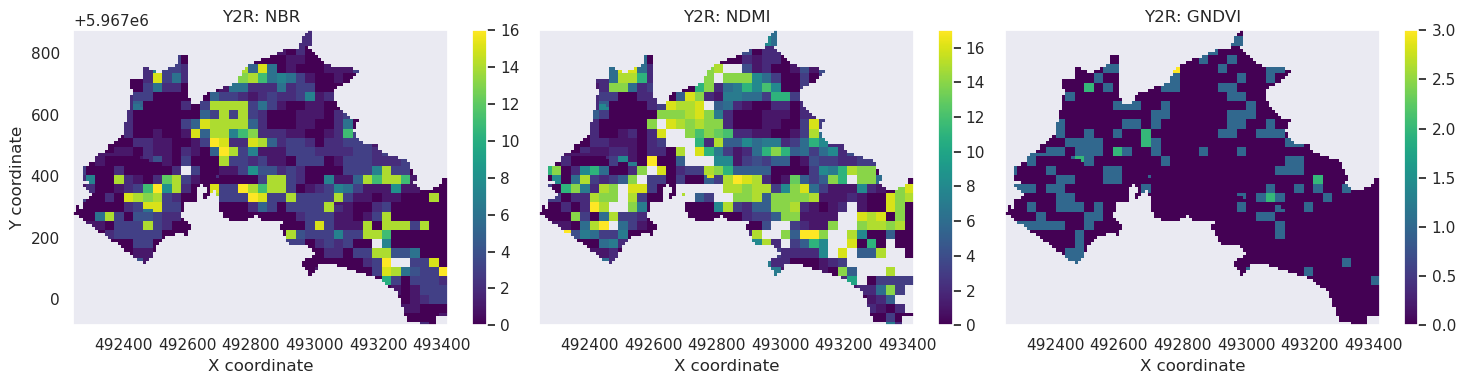

In [23]:
y2r = ra_hist_pixel.y2r()
plot_metrics(y2r)

### R80P

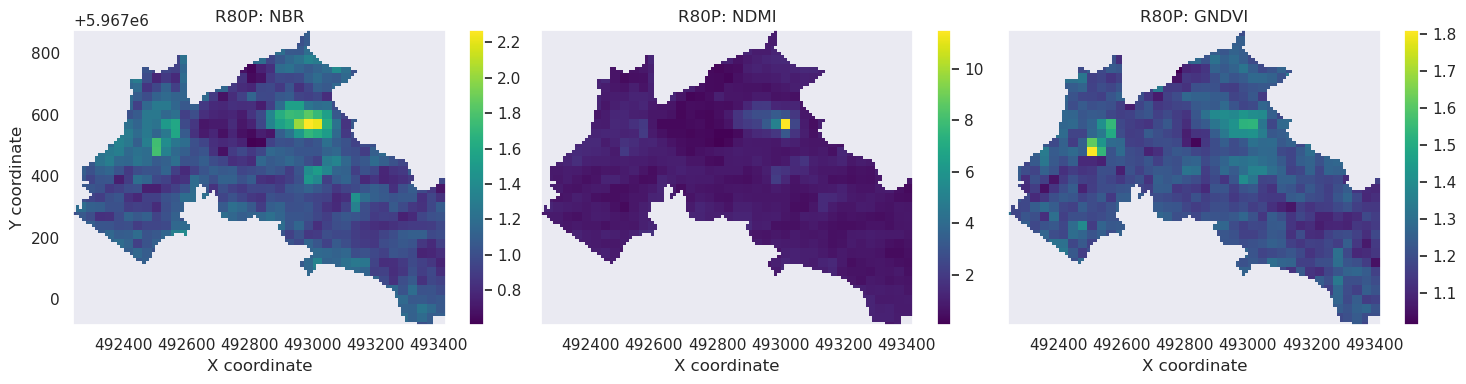

In [24]:
r80p = ra_hist_pixel.r80p(timestep=4)
plot_metrics(r80p)

### YrYr

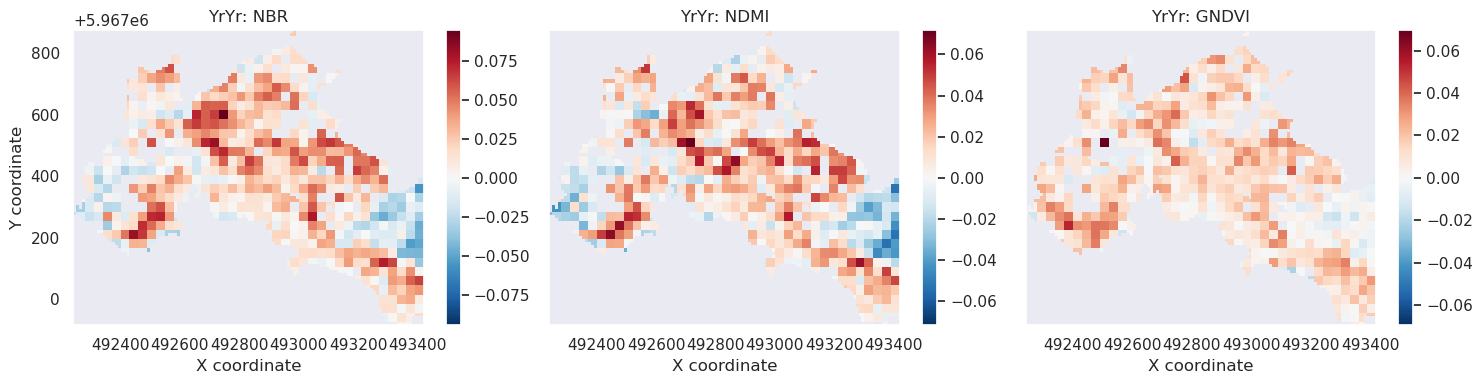

In [25]:
yryr = ra_hist_pixel.yryr(timestep=4)
plot_metrics(yryr)

### dNBR

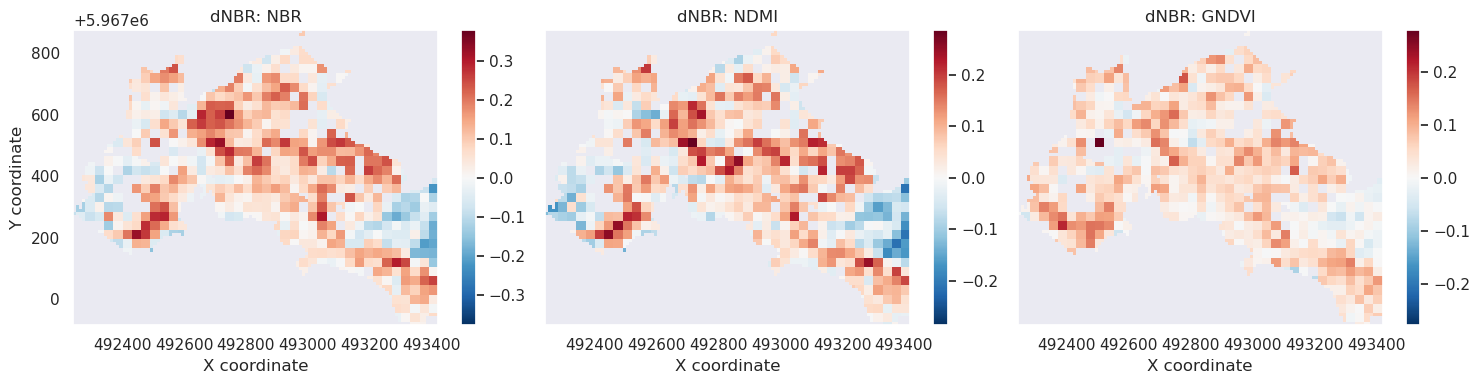

In [26]:
dNBR = ra_hist_pixel.dnbr(timestep=4)
plot_metrics(dNBR)

###  Writing Results

To write your metric results to raster files, the simpliest way is to use `rioxarray`'s `to_raster` function:


In [ ]:
y2r[0,:,:,:].rio.to_raster("./y2r.tif")